In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 10)

Populating the interactive namespace from numpy and matplotlib


In [2]:
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(api_key="xktj4EX0zB8YcQ3BEaFwOQYpu")

import tensorflow as tf
import numpy as np
import os
import fnmatch
import pandas as pd

import sklearn.preprocessing as preprocessing
from sklearn import manifold, datasets
from sklearn import feature_selection

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from time import time

from scipy.stats import kendalltau as kt
from scipy.stats import ttest_rel as tt

import seaborn as sns

COMET WARNING: We detected that you are running inside a Ipython/Jupyter notebook environment but we cannot save your notebook source code. Please be sure to have installed comet_ml as a notebook server extension by running:
jupyter comet_ml enable
COMET INFO: old comet version (1.0.9) detected. current: 1.0.19 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET WARNING: Comet.ml support for Ipython Notebook is limited at the moment, automatic monitoring and stdout capturing is deactivated
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/incnas/general/580a5d03f058474d80a3c041e23fd873

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from shutil import copyfile
import scipy.misc

In [4]:
sns.set(style="white")

## Load Data

In [5]:
path = "data\\heparin\\agg\\ids.csv"
biomarkers_path = "data\\heparin\\biomarkers.xlsx"
root_dir = "data\\heparin\\agg\\"

In [6]:
data = pd.read_csv(path, index_col=0)
data = data[~data['name'].str.contains("_flipped")]

In [7]:
data = data.sample(frac=1)

In [8]:
data['cluster'] = 0

In [9]:
data.head()

,name,date,flow_rate,source,peak_val,num_peaks,eccentricity,euler_number,extent,inertia_tensor,mean_intensity,moments,orientation,perimeter,volume,area,sd,num_local_peaks,cluster
0,0,2018.5.15,1800,13.10 s.tifheightmap.mat,4.292725,1,0.942129,1,0.390345,[[ 200.86457258 -238.08316531]\r\n [-238.08316...,1.750114,[[1.87600000e+03 7.44130000e+04 3.91209700e+06...,-1.074760,238.551299,3283.213594,1876,0.965127,5,0
112,112,2018.6.6,3600,11.20 s.tifheightmap.mat,10.304043,1,0.955308,1,0.295762,[[ 587.7602705 -905.01756342]\r\n [-905.01756...,3.704566,[[8.34700000e+03 1.26161000e+06 2.20928718e+08...,-1.301944,852.808225,30922.009650,8347,1.956599,17,0
110,110,2018.6.6,3600,0.87 s.tifheightmap.mat,6.267800,1,0.930192,1,0.482476,[[276.31205057 313.16199939]\r\n [313.16199939...,3.331903,[[3.41400000e+03 1.71951000e+05 1.12816250e+07...,1.118045,308.693434,11375.117161,3414,1.828141,5,0
79,79,2018.6.5,3600,15.20 s.tifheightmap.mat,15.171350,1,0.728810,1,0.751187,[[ 91.6644604 11.53887085]\r\n [ 11.53887085...,8.985694,[[1.58200000e+03 3.82170000e+04 1.22599700e+06...,1.457088,160.811183,14215.368268,1582,4.699943,1,0
18,18,2018.5.15,3600,7.12 s.tifheightmap.mat,4.080140,1,0.917901,1,0.726667,[[ 65.05726547 -50.29802771]\r\n [-50.29802771...,2.417823,[[1.74400000e+03 6.88020000e+04 3.32429200e+06...,-1.400982,187.781746,4216.683269,1744,1.247176,3,0


In [10]:
donor = data['date']
samples = data.drop(columns=['name','date','source','moments','orientation','inertia_tensor'])
train_data = samples.drop(columns=['flow_rate'])

In [11]:
samples.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138 entries, 0 to 127
Data columns (total 13 columns):
flow_rate          138 non-null int64
peak_val           138 non-null float64
num_peaks          138 non-null int64
eccentricity       138 non-null float64
euler_number       138 non-null int64
extent             138 non-null float64
mean_intensity     138 non-null float64
perimeter          138 non-null float64
volume             138 non-null float64
area               138 non-null int64
sd                 138 non-null float64
num_local_peaks    138 non-null int64
cluster            138 non-null int64
dtypes: float64(7), int64(6)
memory usage: 15.1 KB


In [12]:
points = train_data.as_matrix()
normalized = preprocessing.Normalizer().fit_transform(points)
standardize = preprocessing.scale(points)

df_standardize = preprocessing.scale(samples.as_matrix())
df_normalize = preprocessing.Normalizer().fit_transform(samples.as_matrix())
df_raw = samples.as_matrix()

In [13]:
normalized.shape

(138, 12)

## Data Analysis

In [14]:
biomarkers = pd.read_excel(biomarkers_path)
biomarkers = biomarkers.rename(columns=lambda x: x.strip())

In [15]:
biomarkers.head()

,Donor,Sample date measured,FSC-A Median,SCC-A Median,GPVI Geomean,ADAM10 Geomean,AK2 Geomean,CD9 Geomean,CD41 Geomean,RCA FITC Geomean,...,HGB g/L,HCT L/L,MCV fL,MCH pg,MCHC g/L,RDW %CV,PLT x10^9/L,MPV fL,PLT PRP count 10^9/L,MPV PRP fL
0,1,20180515,3866,749,921,81.9,1827,114,1308,5.96,...,144,0.427,89.5,30.2,337,13.3,289,6.6,288,6.1
1,2,20180601,1298,567,2718,1281.0,1112,134,2462,1608.00,...,132,0.392,83.5,28.1,337,14.8,209,7.3,297,7.1
2,3,20180605,4417,820,1558,96.3,1558,173,2500,154.00,...,122,0.370,80.2,26.5,330,14.1,303,6.9,95,6.3
3,4,20180606,4788,959,4882,111.0,2632,108,2960,454.00,...,140,0.402,88.2,30.7,348,13.3,121,8.8,121,6.7


In [16]:
biomarker_values = biomarkers.drop(columns=['Donor','Sample date measured'])

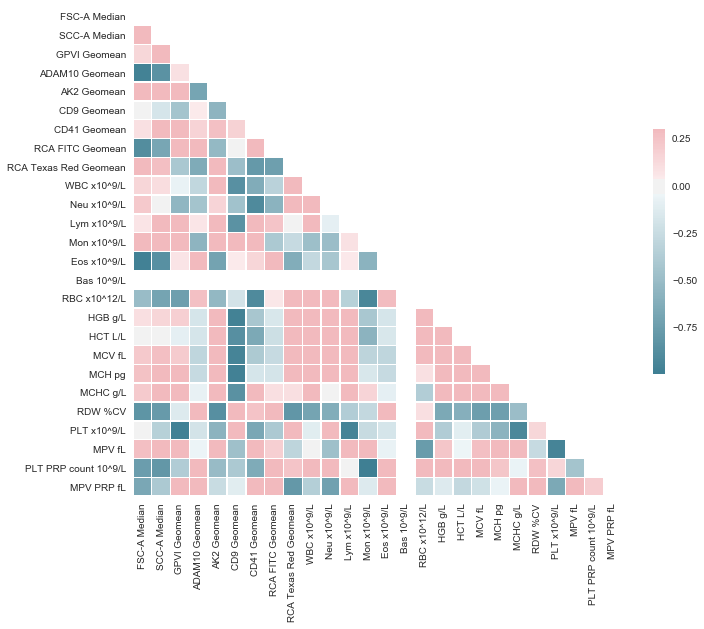

In [17]:
# Compute the correlation matrix
corr = pd.DataFrame(data=biomarker_values,columns=list(biomarker_values)).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [18]:
biomarkers_ranked = biomarker_values.rank()

biomarkers_merged = []
biomarkers_merged.append([biomarkers_ranked['FSC-A Median']])

for column in biomarkers_ranked:
    found_match = False
    for merged in biomarkers_merged:
        merged_bm = merged[0]
        
        #print(type(merged_bm))
        
        if merged_bm.equals(biomarkers_ranked[column]):
            merged.append(biomarkers_ranked[column])
            found_match = True
            break
    
    if not found_match:
        biomarkers_merged.append([biomarkers_ranked[column]])

for markers in biomarkers_merged:
    marker = markers[0]
    print(marker.values)
    
print(len(biomarkers_merged))

[2. 1. 3. 4.]
[1. 3. 2. 4.]
[1. 4. 2. 3.]
[3. 1. 2. 4.]
[2. 3. 4. 1.]
[1. 2. 3. 4.]
[4. 1. 2. 3.]
[4. 2. 1. 3.]
[2. 3. 1. 4.]
[1.5 1.5 3.5 3.5]
[2. 4. 2. 2.]
[2.5 2.5 2.5 2.5]
[4. 3. 2. 1.]
[3. 2. 1. 4.]
[2.5 2.5 1.  4. ]
[1.5 4.  3.  1.5]
[3. 2. 4. 1.]
[3. 4. 1. 2.]
18


## Visualisation of features:

In [19]:
pd.DataFrame(data=df_raw,columns=list(samples)).corr()

,flow_rate,peak_val,num_peaks,eccentricity,euler_number,extent,mean_intensity,perimeter,volume,area,sd,num_local_peaks,cluster
flow_rate,1.000000,0.075543,-0.021152,0.006920,-0.120322,0.186008,0.070068,-0.213257,-0.101856,-0.190627,0.089280,-0.216003,NaN
peak_val,0.075543,1.000000,-0.153626,-0.329836,-0.252573,0.296182,0.934166,0.150767,0.697604,0.291970,0.958615,0.160601,NaN
num_peaks,-0.021152,-0.153626,1.000000,0.102431,-0.076629,-0.499398,-0.186276,0.338630,-0.077538,0.081746,-0.221197,0.127379,NaN
eccentricity,0.006920,-0.329836,0.102431,1.000000,0.074012,-0.365015,-0.354118,0.137478,-0.180972,0.030462,-0.365929,0.069327,NaN
euler_number,-0.120322,-0.252573,-0.076629,0.074012,1.000000,0.019203,-0.171563,-0.236420,-0.291093,-0.218026,-0.190473,-0.238853,NaN
extent,0.186008,0.296182,-0.499398,-0.365015,0.019203,1.000000,0.390384,-0.563686,0.033020,-0.280116,0.420531,-0.354020,NaN
mean_intensity,0.070068,0.934166,-0.186276,-0.354118,-0.171563,0.390384,1.000000,0.055409,0.687721,0.259105,0.989229,0.067009,NaN
perimeter,-0.213257,0.150767,0.338630,0.137478,-0.236420,-0.563686,0.055409,1.000000,0.560486,0.870601,0.029385,0.795438,NaN
volume,-0.101856,0.697604,-0.077538,-0.180972,-0.291093,0.033020,0.687721,0.560486,1.000000,0.794587,0.685238,0.587787,NaN
area,-0.190627,0.291970,0.081746,0.030462,-0.218026,-0.280116,0.259105,0.870601,0.794587,1.000000,0.239114,0.848205,NaN


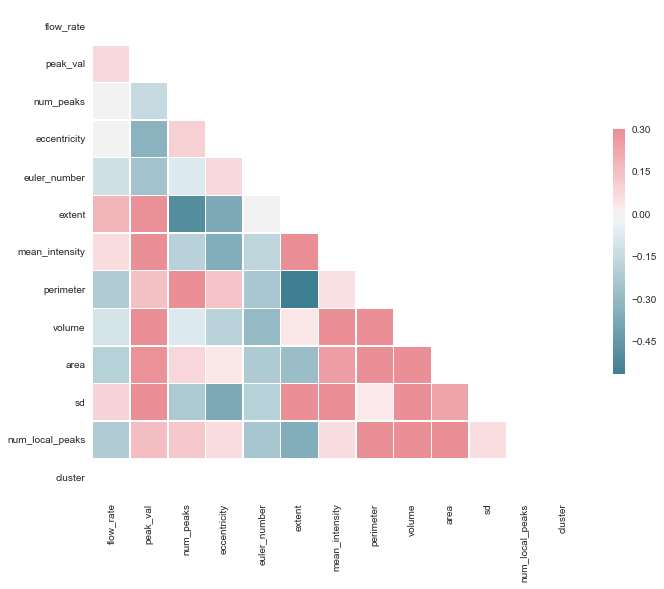

In [20]:
# Generate a large random dataset
#rs = np.random.RandomState(33)
#d = pd.DataFrame(data=rs.normal(size=(100, 26)),
                 #columns=list(ascii_letters[26:]))

# Compute the correlation matrix
corr = pd.DataFrame(data=df_raw,columns=list(samples)).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [21]:
data.groupby(['flow_rate','date']).mean().rank()

peak_val  num_peaks  eccentricity  euler_number  extent  \
flow_rate date                                                                 
1800      2018.5.15       2.0        8.5           7.0           7.5     3.0   
          2018.6.1       11.0        2.5           1.0           2.0    10.0   
          2018.6.5        9.0        2.5           2.0           7.5     8.0   
          2018.6.6        1.0        5.0          12.0           7.5     1.0   
3600      2018.5.15       4.0        7.0           5.0           7.5    11.0   
          2018.6.1       10.0       12.0           6.0           7.5     7.0   
          2018.6.5        6.0       10.0           9.0           7.5     4.0   
          2018.6.6        8.0       11.0          11.0           7.5     2.0   
7200      2018.5.15      12.0        8.5          10.0           1.0     5.0   
          2018.6.1        7.0        6.0           8.0           7.5     6.0   
          2018.6.5        5.0        2.5           3.0           7.5    12.0   
          2018.6.6        3.0        2.5           4.0           7.5     9.0   

                     mean_intensity  orientation  perimeter  volume  area  \
flow_rate date                                                              
1800      2018.5.15             2.0          9.0        6.0     2.0   6.0   
          2018.6.1             11.0          8.0       11.0    12.0  12.0   
          2018.6.5              9.0          7.0        5.0     7.0   4.0   
          2018.6.6              1.0          2.0        7.0     4.0   7.0   
3600      2018.5.15             4.0          6.0        3.0     5.0   3.0   
          2018.6.1             10.0          1.0       10.0    11.0  11.0   
          2018.6.5              8.0         12.0        8.0     8.0   8.0   
          2018.6.6              6.0          3.0       12.0     9.0  10.0   
7200      2018.5.15            12.0         11.0        9.0    10.0   9.0   
          2018.6.1              7.0          5.0        2.0     6.0   2.0   
          2018.6.5              5.0         10.0        4.0     3.0   5.0   
          2018.6.6              3.0          4.0        1.0     1.0   1.0   

                       sd  num_local_peaks  cluster  
flow_rate date                                       
1800      2018.5.15   2.0              8.0      6.5  
          2018.6.1   11.0             12.0      6.5  
          2018.6.5    9.0              4.0      6.5  
          2018.6.6    1.0              7.0      6.5  
3600      2018.5.15   4.0              3.0      6.5  
          2018.6.1   10.0             10.0      6.5  
          2018.6.5    6.0              6.0      6.5  
          2018.6.6    7.0             11.0      6.5  
7200      2018.5.15  12.0              9.0      6.5  
          2018.6.1    8.0              2.0      6.5  
          2018.6.5    5.0              5.0      6.5  
          2018.6.6    3.0              1.0      6.5

In [22]:
data.groupby(['date','flow_rate']).count()

name  source  peak_val  num_peaks  eccentricity  \
date      flow_rate                                                    
2018.5.15 1800         10      10        10         10            10   
          3600         11      11        11         11            11   
          7200         10      10        10         10            10   
2018.6.1  1800         12      12        12         12            12   
          3600         13      13        13         13            13   
          7200         13      13        13         13            13   
2018.6.5  1800          6       6         6          6             6   
          3600         13      13        13         13            13   
          7200          8       8         8          8             8   
2018.6.6  1800         11      11        11         11            11   
          3600         24      24        24         24            24   
          7200          7       7         7          7             7   

                     euler_number  extent  inertia_tensor  mean_intensity  \
date      flow_rate                                                         
2018.5.15 1800                 10      10              10              10   
          3600                 11      11              11              11   
          7200                 10      10              10              10   
2018.6.1  1800                 12      12              12              12   
          3600                 13      13              13              13   
          7200                 13      13              13              13   
2018.6.5  1800                  6       6               6               6   
          3600                 13      13              13              13   
          7200                  8       8               8               8   
2018.6.6  1800                 11      11              11              11   
          3600                 24      24              24              24   
          7200                  7       7               7               7   

                     moments  orientation  perimeter  volume  area  sd  \
date      flow_rate                                                      
2018.5.15 1800            10           10         10      10    10  10   
          3600            11           11         11      11    11  11   
          7200            10           10         10      10    10  10   
2018.6.1  1800            12           12         12      12    12  12   
          3600            13           13         13      13    13  13   
          7200            13           13         13      13    13  13   
2018.6.5  1800             6            6          6       6     6   6   
          3600            13           13         13      13    13  13   
          7200             8            8          8       8     8   8   
2018.6.6  1800            11           11         11      11    11  11   
          3600            24           24         24      24    24  24   
          7200             7            7          7       7     7   7   

                     num_local_peaks  cluster  
date      flow_rate                            
2018.5.15 1800                    10       10  
          3600                    11       11  
          7200                    10       10  
2018.6.1  1800                    12       12  
          3600                    13       13  
          7200                    13       13  
2018.6.5  1800                     6        6  
          3600                    13       13  
          7200                     8        8  
2018.6.6  1800                    11       11  
          3600                    24       24  
          7200                     7        7

In [23]:
data.groupby('date').mean().drop(columns=['flow_rate']).rank()

,peak_val,num_peaks,eccentricity,euler_number,extent,mean_intensity,orientation,perimeter,volume,area,sd,num_local_peaks,cluster
date,,,,,,,,,,,,,
2018.5.15,3.0,4.0,3.0,1.0,2.0,3.0,3.0,2.0,3.0,2.0,3.0,2.0,2.5
2018.6.1,4.0,2.0,1.0,2.0,4.0,4.0,2.0,3.0,4.0,4.0,4.0,3.0,2.5
2018.6.5,2.0,1.0,2.0,3.5,3.0,2.0,4.0,1.0,1.0,1.0,2.0,1.0,2.5
2018.6.6,1.0,3.0,4.0,3.5,1.0,1.0,1.0,4.0,2.0,3.0,1.0,4.0,2.5


In [24]:
samples_ranked_mean = data.groupby('date').mean().drop(columns=['flow_rate']).rank()
samples_ranked_sum = data.groupby('date').sum().drop(columns=['flow_rate']).rank()

In [25]:
samples_ranked = samples_ranked_mean
samples_ranked['count'] = data.groupby(['date']).count().rank()['area'].reshape(4)

samples_merged = []
samples_merged.append([samples_ranked['peak_val']])

for column in samples_ranked:
    found_match = False
    for merged in samples_merged:
        merged_s = merged[0]
                
        if merged_s.equals(samples_ranked[column]):
            merged.append(samples_ranked[column])
            found_match = True
            break
    
    if not found_match:
        samples_merged.append([samples_ranked[column]])

print(len(samples_merged))
        
for sm in samples_merged:
    sample = sm[0]
    print(sample.values)

10
[3. 4. 2. 1.]
[4. 2. 1. 3.]
[3. 1. 2. 4.]
[1.  2.  3.5 3.5]
[2. 4. 3. 1.]
[3. 2. 4. 1.]
[2. 3. 1. 4.]
[3. 4. 1. 2.]
[2. 4. 1. 3.]
[2.5 2.5 2.5 2.5]


C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [26]:
kendall_table = []
p_table = []

perfect_matches = []

for marker in biomarkers_ranked:
    marker_list = []
    p_list = []
    
    for feature in samples_ranked:
        tau, p_value = kt(biomarkers_ranked[marker],samples_ranked[feature])
        marker_list.append(tau)
        p_list.append(p_value)
        
        if abs(tau) == 1:
            perfect_matches.append((marker, feature))
        
    kendall_table.append(marker_list)
    p_table.append(p_list)

kendall_df = pd.DataFrame.from_records(kendall_table,columns=list(samples_ranked))
kendall_df['biomarker'] = list(biomarkers_ranked)
kendall_df = kendall_df.set_index('biomarker')

p_table = pd.DataFrame.from_records(p_table,columns=list(samples_ranked))
p_table['biomarker'] = list(biomarkers_ranked)
p_table = p_table.set_index('biomarker')

In [27]:
print(perfect_matches)

[('FSC-A Median', 'peak_val'), ('FSC-A Median', 'mean_intensity'), ('FSC-A Median', 'sd'), ('SCC-A Median', 'peak_val'), ('SCC-A Median', 'mean_intensity'), ('SCC-A Median', 'sd'), ('AK2 Geomean', 'eccentricity'), ('AK2 Geomean', 'extent'), ('WBC x10^9/L', 'num_peaks'), ('Lym x10^9/L', 'orientation'), ('Lym x10^9/L', 'perimeter'), ('Lym x10^9/L', 'num_local_peaks'), ('Lym x10^9/L', 'count'), ('HGB g/L', 'num_peaks'), ('HCT L/L', 'num_peaks'), ('MCV fL', 'num_peaks'), ('PLT x10^9/L', 'orientation'), ('PLT x10^9/L', 'perimeter'), ('PLT x10^9/L', 'num_local_peaks'), ('PLT x10^9/L', 'count'), ('PLT PRP count 10^9/L', 'volume')]


In [28]:
kendall_df.shape

(26, 14)

In [29]:
kendall_df.head()

,peak_val,num_peaks,eccentricity,euler_number,extent,mean_intensity,orientation,perimeter,volume,area,sd,num_local_peaks,cluster,count
biomarker,,,,,,,,,,,,,,
FSC-A Median,-1.000000,0.000000,0.666667,0.547723,-0.666667,-1.000000,0.000000,0.000000,-0.666667,-0.333333,-1.000000,0.000000,NaN,0.000000
SCC-A Median,-1.000000,0.000000,0.666667,0.547723,-0.666667,-1.000000,0.000000,0.000000,-0.666667,-0.333333,-1.000000,0.000000,NaN,0.000000
GPVI Geomean,-0.333333,0.000000,0.000000,0.547723,0.000000,-0.333333,-0.666667,0.666667,0.000000,0.333333,-0.333333,0.666667,NaN,0.666667
ADAM10 Geomean,0.000000,-0.333333,-0.333333,0.182574,0.333333,0.000000,-0.333333,0.333333,0.333333,0.666667,0.000000,0.333333,NaN,0.333333
AK2 Geomean,-0.666667,0.333333,1.000000,0.182574,-1.000000,-0.666667,-0.333333,0.333333,-0.333333,0.000000,-0.666667,0.333333,NaN,0.333333


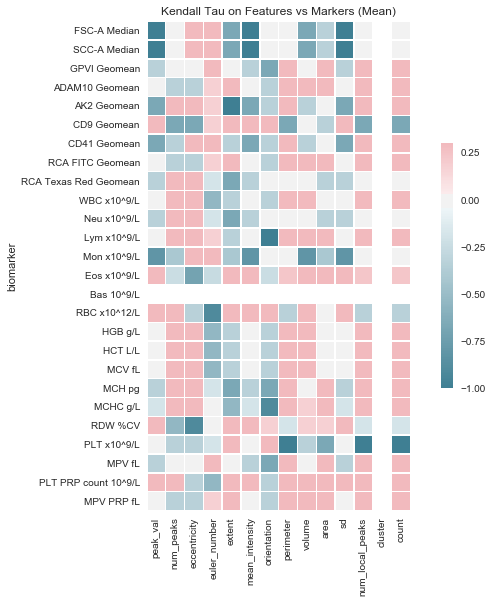

In [30]:
# Generate a mask for the upper triangle
mask = np.zeros_like(kendall_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
plt.title('Kendall Tau on Features vs Markers (Mean)')

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(kendall_df, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

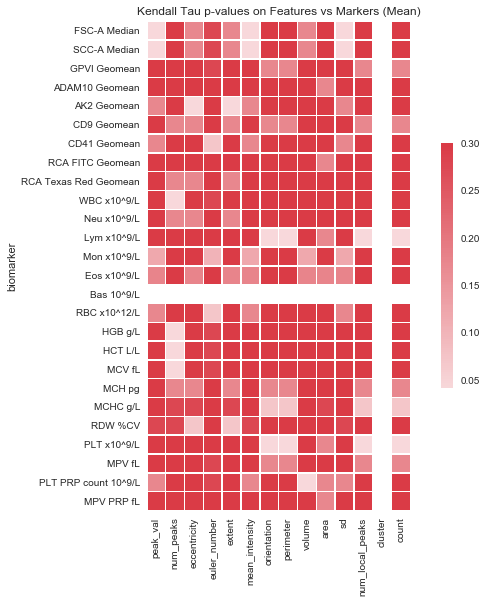

In [31]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
plt.title('Kendall Tau p-values on Features vs Markers (Mean)')

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(p_table, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## t-Test

In [32]:
t_list = []
p_table = []

for marker in samples:
    marker_list = []
    p_list = []
    for feature in samples:
        t_score, p_value = tt(samples[marker],samples[feature])
        marker_list.append(t_score)
        p_list.append(p_value)
        
    t_list.append(marker_list)
    p_table.append(p_list)

t_score_table = pd.DataFrame.from_records(t_list,columns=list(samples))
t_score_table['feature'] = list(samples)
t_score_table = t_score_table.set_index('feature')

p_table = pd.DataFrame.from_records(p_table,columns=list(samples))
p_table['feature'] = list(samples)
p_table = p_table.set_index('feature')

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


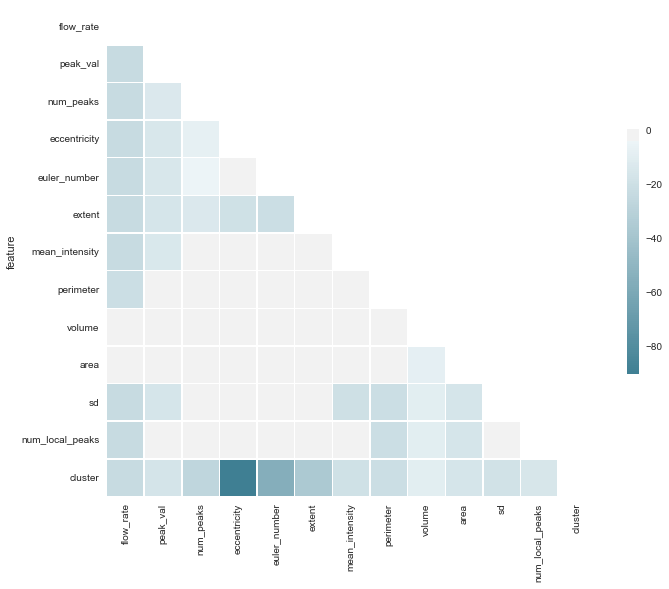

In [33]:
# Generate a mask for the upper triangle
mask = np.zeros_like(t_score_table, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(t_score_table, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

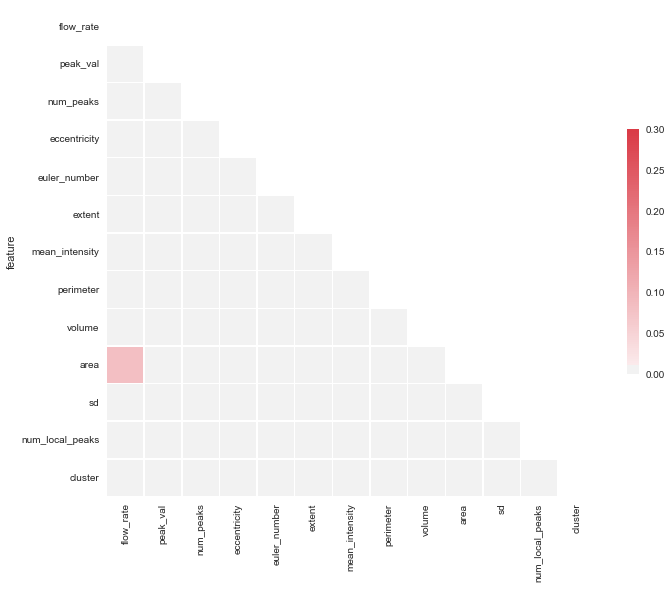

In [34]:
# Generate a mask for the upper triangle
mask = np.zeros_like(p_table, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(p_table, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Graphs

In [35]:
donor_count = donor.value_counts()

In [36]:
donors = data['date'].unique()

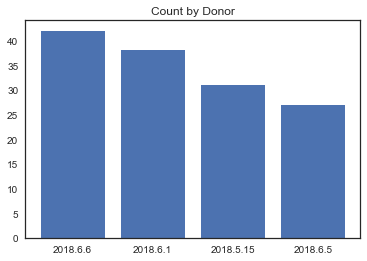

In [37]:
t = data[data['flow_rate']==1800]
u = data[data['flow_rate']==3600]
v = data[data['flow_rate']==7200]

a = data[data['cluster']==0]
b = data[data['cluster']==1]
c = data[data['cluster']==2]

'''p1 = plt.bar(ind, a, width)
p2 = plt.bar(ind, b, width,bottom=a)
p3 = plt.bar(ind, c, width,bottom=b)

plt.xticks(ind, ('1800', '3600', '7200'))

plt.legend((p1[0], p2[0], p3[0]), ('1', '2', '3'))

plt.subplot(131)
plt.title("Num Peaks by flow rate")
plt.plot(a, 'r^', b, 'bs', c, 'g^')

plt.subplot(121)
plt.title("Num Peaks by cluster")
plt.plot(t, 'r^', u, 'bs', v, 'g^')'''

#plt.subplot(121)
#plt.title("Count by Cluster")
#plt.hist(donor_count.values, bins=4)

#fig, ax = plt.subplots()
#ax.yaxis.set_major_formatter(formatter)

x = np.arange(4)
#plt.subplot(121)
plt.title("Count by Donor")
plt.bar(x, donor_count.values)
plt.xticks(x, donor_count.index)
plt.show()

plt.show()

Number of different blobs as identified by Otsu's

Num Peaks by Donor: 
2018.5.15: 1    23
2     8
Name: num_peaks, dtype: int64
2018.6.6: 1    35
2     5
3     2
Name: num_peaks, dtype: int64
2018.6.5: 1    23
2     4
Name: num_peaks, dtype: int64
2018.6.1: 1    33
2     4
5     1
Name: num_peaks, dtype: int64
Num Peaks by Flow Rate: 
1800: [35, 4, 0]
3600: [46, 12, 2, 1]
7200: [33, 5]


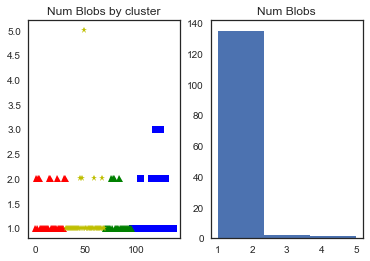

In [38]:
t = data[data['date']==donors[0]]['num_peaks']
u = data[data['date']==donors[1]]['num_peaks']
v = data[data['date']==donors[2]]['num_peaks']
w = data[data['date']==donors[3]]['num_peaks']

print("Num Peaks by Donor: ")
print(donors[0] + ": " + str(t.value_counts()))
print(donors[1] + ": " + str(u.value_counts()))
print(donors[2] + ": " + str(v.value_counts()))
print(donors[3] + ": " + str(w.value_counts()))

N = 4

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

a = data[data['flow_rate']==1800]
a = a.groupby('num_peaks').size().tolist()
a.append(0)

b = data[data['flow_rate']==3600]
b = b.groupby('num_peaks').size().tolist()

c = data[data['flow_rate']==7200]
c = c.groupby('num_peaks').size().tolist()

print("Num Peaks by Flow Rate: ")
print("1800: " + str(a))
print("3600: " + str(b))
print("7200: " + str(c))

'''p1 = plt.bar(ind, a, width)
p2 = plt.bar(ind, b, width,bottom=a)
p3 = plt.bar(ind, c, width,bottom=b)

plt.xticks(ind, ('1800', '3600', '7200'))

plt.legend((p1[0], p2[0], p3[0]), ('1', '2', '3'))

plt.subplot(131)
plt.title("Num Blobs by flow rate")
plt.plot(a, 'r^', b, 'bs', c, 'g^')'''

plt.subplot(121)
plt.title("Num Blobs by cluster")
plt.plot(t, 'r^', u, 'bs', v, 'g^', w, 'y*')

plt.subplot(122)
plt.title("Num Blobs")
plt.hist(data['num_peaks'], bins=3)

plt.show()

Peak Value of each image

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


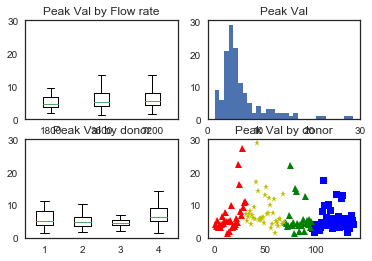

In [39]:
t = data[data['date']==donors[0]]['peak_val']
u = data[data['date']==donors[1]]['peak_val']
v = data[data['date']==donors[2]]['peak_val']
w = data[data['date']==donors[3]]['peak_val']

a = data[data['flow_rate']==1800]['peak_val']
b = data[data['flow_rate']==3600]['peak_val']
c = data[data['flow_rate']==7200]['peak_val']

# red dashes, blue squares and green triangles
#plt.plot(data[data['cluster']==0]['peak_val'], t, 'r--', u, u, 'bs', v, v, 'g^')
plt.subplot(221)
plt.title("Peak Val by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])

plt.subplot(222)
plt.title("Peak Val")
plt.hist(data['peak_val'], bins=30)

plt.subplot(223)
plt.title("Peak Val by donor")
plt.boxplot([t,u,v,w], labels=['1','2','3','4'])

plt.subplot(224)
plt.title("Peak Val by donor")
plt.plot(t, 'r^', u, 'bs', v, 'g^', w, 'y*')

plt.show()

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


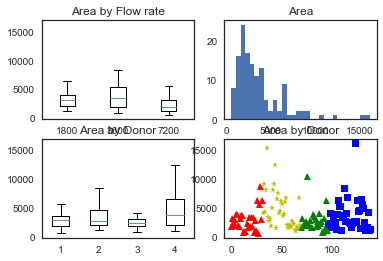

In [40]:
t = data[data['date']==donors[0]]['area']
u = data[data['date']==donors[1]]['area']
v = data[data['date']==donors[2]]['area']
w = data[data['date']==donors[3]]['area']

a = data[data['flow_rate']==1800]['area']
b = data[data['flow_rate']==3600]['area']
c = data[data['flow_rate']==7200]['area']

# red dashes, blue squares and green triangles
#plt.plot(data[data['cluster']==0]['peak_val'], t, 'r--', u, u, 'bs', v, v, 'g^')
plt.subplot(221)
plt.title("Area by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])

plt.subplot(222)
plt.title("Area")
plt.hist(data['area'], bins=30)

plt.subplot(223)
plt.title("Area by Donor")
plt.boxplot([t,u,v,w], labels=['1','2','3','4'])

plt.subplot(224)
plt.title("Area by Donor")
plt.plot(t, 'r^', u, 'bs', v, 'g^', w, 'y*')

plt.show()

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


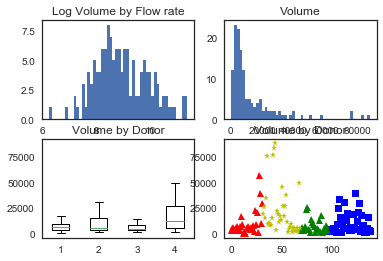

In [41]:
t = data[data['date']==donors[0]]['volume']
u = data[data['date']==donors[1]]['volume']
v = data[data['date']==donors[2]]['volume']
w = data[data['date']==donors[3]]['volume']

a = data[data['flow_rate']==1800]['volume']
b = data[data['flow_rate']==3600]['volume']
c = data[data['flow_rate']==7200]['volume']

log = data['volume'].apply(np.log)

plt.subplot(221)
plt.title("Log Volume by Flow rate")
#plt.boxplot([a,b,c], labels=['1800','3600','7200'])
plt.hist(log, bins=50)

plt.subplot(222)
plt.title("Volume")
plt.hist(data['volume'], bins=50)

plt.subplot(223)
plt.title("Volume by Donor")
plt.boxplot([t,u,v,w], labels=['1','2','3','4'])

plt.subplot(224)
plt.title("Volume by Donor")
plt.plot(t, 'r^', u, 'bs', v, 'g^', w, 'y*')

plt.show()

Eccentricity of the ellipse that has the same second-moments as the region. The eccentricity is the ratio of the focal distance (distance between focal points) over the major axis length. The value is in the interval [0, 1). When it is 0, the ellipse becomes a circle.

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


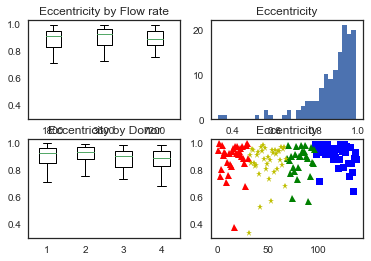

In [42]:
t = data[data['date']==donors[0]]['eccentricity']
u = data[data['date']==donors[1]]['eccentricity']
v = data[data['date']==donors[2]]['eccentricity']
w = data[data['date']==donors[3]]['eccentricity']

a = data[data['flow_rate']==1800]['eccentricity']
b = data[data['flow_rate']==3600]['eccentricity']
c = data[data['flow_rate']==7200]['eccentricity']

plt.subplot(221)
plt.title("Eccentricity by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])

plt.subplot(222)
plt.title("Eccentricity")
plt.hist(data['eccentricity'], bins=30)

plt.subplot(223)
plt.title("Eccentricity by Donor")
plt.boxplot([t,u,v,w], labels=['1','2','3','4'])

plt.subplot(224)
plt.title("Eccentricity")
plt.plot(t, 'r^', u, 'bs', v, 'g^', w, 'y*')


plt.show()

Euler characteristic of region. Computed as number of objects (= 1) subtracted by number of holes (8-connectivity).

Euler Number by Flow Rate: 
1800: [1, 38]
3600: [61]
7200: [1, 1, 36]


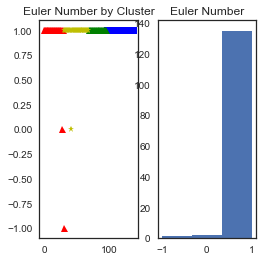

In [43]:
t = data[data['date']==donors[0]]['euler_number']
u = data[data['date']==donors[1]]['euler_number']
v = data[data['date']==donors[2]]['euler_number']
w = data[data['date']==donors[3]]['euler_number']

a = data[data['flow_rate']==1800]
a = a.groupby('euler_number').size().tolist()

b = data[data['flow_rate']==3600]
b = b.groupby('euler_number').size().tolist()

c = data[data['flow_rate']==7200]
c = c.groupby('euler_number').size().tolist()

print("Euler Number by Flow Rate: ")
print("1800: " + str(a))
print("3600: " + str(b))
print("7200: " + str(c))

'''plt.subplot(131)
plt.title("Euler Number by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])'''

plt.subplot(132)
plt.title("Euler Number by Cluster")
plt.plot(t, 'r^', u, 'bs', v, 'g^', w, 'y*')

plt.subplot(133)
plt.title("Euler Number")
plt.hist(data['euler_number'], bins=3)

plt.show()

Ratio of pixels in the region to pixels in the total bounding box. Computed as area / (rows * cols)

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


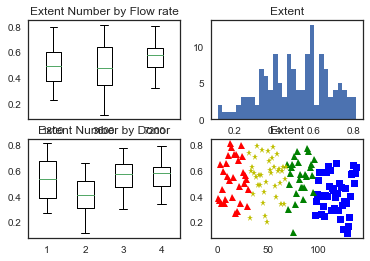

In [44]:
t = data[data['date']==donors[0]]['extent']
u = data[data['date']==donors[1]]['extent']
v = data[data['date']==donors[2]]['extent']
w = data[data['date']==donors[3]]['extent']

a = data[data['flow_rate']==1800]['extent']
b = data[data['flow_rate']==3600]['extent']
c = data[data['flow_rate']==7200]['extent']

plt.subplot(221)
plt.title("Extent Number by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])

plt.subplot(222)
plt.title("Extent")
plt.hist(data['extent'], bins=30)

plt.subplot(223)
plt.title("Extent Number by Donor")
plt.boxplot([t,u,v,w], labels=['1','2','3','4'])

plt.subplot(224)
plt.title("Extent")
plt.plot(t, 'r^', u, 'bs', v, 'g^', w, 'y*')

plt.show()

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


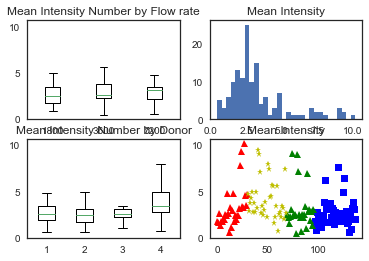

In [45]:
t = data[data['date']==donors[0]]['mean_intensity']
u = data[data['date']==donors[1]]['mean_intensity']
v = data[data['date']==donors[2]]['mean_intensity']
w = data[data['date']==donors[3]]['mean_intensity']

a = data[data['flow_rate']==1800]['mean_intensity']
b = data[data['flow_rate']==3600]['mean_intensity']
c = data[data['flow_rate']==7200]['mean_intensity']

plt.subplot(221)
plt.title("Mean Intensity Number by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])

plt.subplot(222)
plt.title("Mean Intensity")
plt.hist(data['mean_intensity'], bins=30)

plt.subplot(223)
plt.title("Mean Intensity Number by Donor")
plt.boxplot([t,u,v,w], labels=['1','2','3','4'])

plt.subplot(224)
plt.title("Mean Intensity")
plt.plot(t, 'r^', u, 'bs', v, 'g^', w, 'y*')

plt.show()

Angle between the X-axis and the major axis of the ellipse that has the same second-moments as the region. Ranging from -pi/2 to pi/2 in counter-clockwise direction.

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


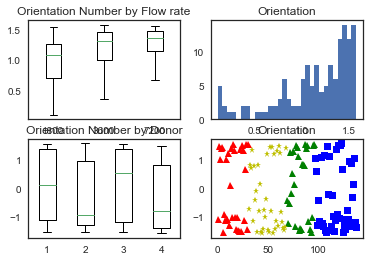

In [46]:
t = data[data['date']==donors[0]]['orientation']
u = data[data['date']==donors[1]]['orientation']
v = data[data['date']==donors[2]]['orientation']
w = data[data['date']==donors[3]]['orientation']

a = pd.DataFrame.abs(data[data['flow_rate']==1800]['orientation'])
b = pd.DataFrame.abs(data[data['flow_rate']==3600]['orientation'])
c = pd.DataFrame.abs(data[data['flow_rate']==7200]['orientation'])

plt.subplot(221)
plt.title("Orientation Number by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])

plt.subplot(222)
plt.title("Orientation")
plt.hist(pd.DataFrame.abs(data['orientation']), bins=30)

plt.subplot(223)
plt.title("Orientation Number by Donor")
plt.boxplot([t,u,v,w], labels=['1','2','3','4'])

plt.subplot(224)
plt.title("Orientation")
plt.plot(t, 'r^', u, 'bs', v, 'g^', w, 'y*')

plt.show()

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


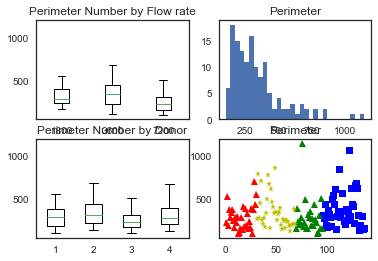

In [47]:
t = data[data['date']==donors[0]]['perimeter']
u = data[data['date']==donors[1]]['perimeter']
v = data[data['date']==donors[2]]['perimeter']
w = data[data['date']==donors[3]]['perimeter']

a = data[data['flow_rate']==1800]['perimeter']
b = data[data['flow_rate']==3600]['perimeter']
c = data[data['flow_rate']==7200]['perimeter']

plt.subplot(221)
plt.title("Perimeter Number by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])

plt.subplot(222)
plt.title("Perimeter")
plt.hist(data['perimeter'], bins=30)

plt.subplot(223)
plt.title("Perimeter Number by Donor")
plt.boxplot([t,u,v,w], labels=['1','2','3','4'])

plt.subplot(224)
plt.title("Perimeter")
plt.plot(t, 'r^', u, 'bs', v, 'g^', w, 'y*')

plt.show()

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


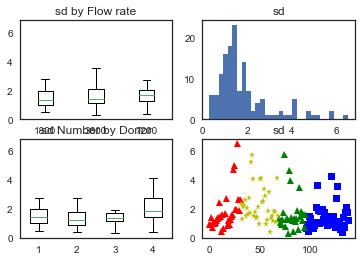

In [48]:
t = data[data['date']==donors[0]]['sd']
u = data[data['date']==donors[1]]['sd']
v = data[data['date']==donors[2]]['sd']
w = data[data['date']==donors[3]]['sd']

a = data[data['flow_rate']==1800]['sd']
b = data[data['flow_rate']==3600]['sd']
c = data[data['flow_rate']==7200]['sd']

plt.subplot(221)
plt.title("sd by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])

plt.subplot(222)
plt.title("sd")
plt.hist(data['sd'], bins=30)

plt.subplot(223)
plt.title("sd Number by Donor")
plt.boxplot([t,u,v,w], labels=['1','2','3','4'])

plt.subplot(224)
plt.title("sd")
plt.plot(t, 'r^', u, 'bs', v, 'g^', w, 'y*')

plt.show()

num_local_peaks by Donor: 
2017.11.23: 5     9
3     5
4     4
6     3
1     3
2     2
15    1
10    1
8     1
7     1
0     1
Name: num_local_peaks, dtype: int64
2017.11.17: 3     7
5     6
1     5
2     4
6     3
4     3
12    2
11    2
10    2
7     2
25    1
17    1
14    1
13    1
9     1
8     1
Name: num_local_peaks, dtype: int64
2017.11.22: 5     8
2     6
1     4
7     2
4     2
3     2
12    1
10    1
6     1
Name: num_local_peaks, dtype: int64
2017.11.09: 4     7
2     6
9     4
5     4
1     4
10    3
7     3
3     2
22    1
18    1
15    1
11    1
6     1
Name: num_local_peaks, dtype: int64
Num Peaks by Flow Rate: 
1800: [3, 1, 7, 3, 12, 1, 2, 1, 4, 1, 1, 1, 1, 1, 0]
3600: [5, 8, 5, 9, 11, 3, 6, 1, 5, 2, 1, 1, 1, 1, 1, 1]
7200: [1, 8, 9, 4, 4, 4, 4, 1, 1, 1, 1]


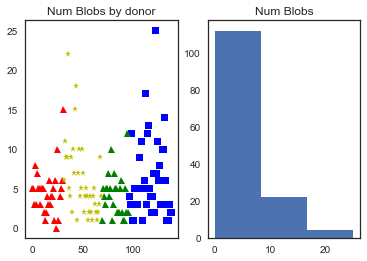

In [49]:
t = data[data['date']==donors[0]]['num_local_peaks']
u = data[data['date']==donors[1]]['num_local_peaks']
v = data[data['date']==donors[2]]['num_local_peaks']
w = data[data['date']==donors[3]]['num_local_peaks']

print("num_local_peaks by Donor: ")
print("2017.11.23: " + str(t.value_counts()))
print("2017.11.17: " + str(u.value_counts()))
print("2017.11.22: " + str(v.value_counts()))
print("2017.11.09: " + str(w.value_counts()))

N = 4

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

a = data[data['flow_rate']==1800]
a = a.groupby('num_local_peaks').size().tolist()
a.append(0)

b = data[data['flow_rate']==3600]
b = b.groupby('num_local_peaks').size().tolist()

c = data[data['flow_rate']==7200]
c = c.groupby('num_local_peaks').size().tolist()

print("Num Peaks by Flow Rate: ")
print("1800: " + str(a))
print("3600: " + str(b))
print("7200: " + str(c))

'''p1 = plt.bar(ind, a, width)
p2 = plt.bar(ind, b, width,bottom=a)
p3 = plt.bar(ind, c, width,bottom=b)

plt.xticks(ind, ('1800', '3600', '7200'))

plt.legend((p1[0], p2[0], p3[0]), ('1', '2', '3'))

plt.subplot(131)
plt.title("Num Blobs by flow rate")
plt.plot(a, 'r^', b, 'bs', c, 'g^')'''

plt.subplot(121)
plt.title("Num Blobs by donor")
plt.plot(t, 'r^', u, 'bs', v, 'g^', w, 'y*')

plt.subplot(122)
plt.title("Num Blobs")
plt.hist(data['num_local_peaks'], bins=3)

plt.show()

## Mutual Information

In [50]:
print(feature_selection.mutual_info_classif(samples.as_matrix(), data['date']))
print(list(train_data.head()))

[0.         0.         0.00146638 0.         0.04981562 0.03438652
 0.07180888 0.01039088 0.00187155 0.1157388  0.         0.02903856
 0.        ]
['peak_val', 'num_peaks', 'eccentricity', 'euler_number', 'extent', 'mean_intensity', 'perimeter', 'volume', 'area', 'sd', 'num_local_peaks', 'cluster']


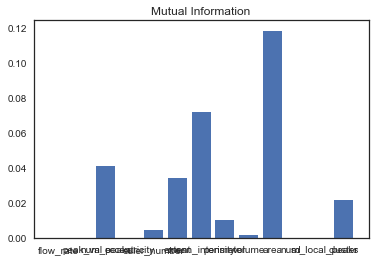

In [51]:
mi = feature_selection.mutual_info_classif(samples.as_matrix(), data['date'])
labels = list(samples.head())

x = np.arange(len(mi))

fig, ax = plt.subplots()
plt.title("Mutual Information")
plt.bar(x, mi)
plt.xticks(x, labels)

plt.show()

### Cluster sizes

### Comparison of Manifold Algorithms

Source: http://scikit-learn.org/stable/auto_examples/manifold/plot_compare_methods.html#sphx-glr-auto-examples-manifold-plot-compare-methods-py

standard: 0.043 sec
ltsa: 0.058 sec
hessian: 0.082 sec
modified: 0.077 sec
Isomap: 0.018 sec
MDS: 0.052 sec
SpectralEmbedding: 0.013 sec
t-SNE: 3.2 sec


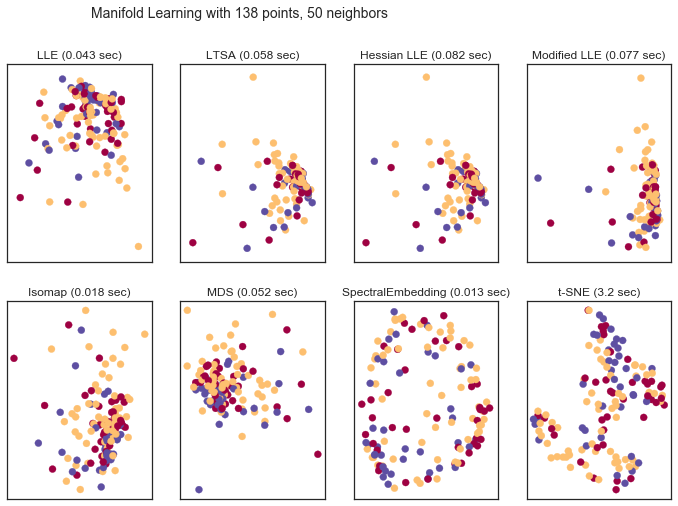

In [52]:
n_neighbors = 50
n_components = 2

fig = plt.figure(figsize=(15, 8))
plt.suptitle("Manifold Learning with %i points, %i neighbors"
             % (len(points), n_neighbors), fontsize=14)

X = standardize
color = data['flow_rate']

''' ax = fig.add_subplot(251, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(4, -72) '''

methods = ['standard', 'ltsa', 'hessian', 'modified']
labels = ['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE']

for i, method in enumerate(methods):
    t0 = time()
    Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                        eigen_solver='auto',
                                        method=method).fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (methods[i], t1 - t0))

    ax = fig.add_subplot(252 + i)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

t0 = time()
Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
t1 = time()
print("Isomap: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(257)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("Isomap (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
mds = manifold.MDS(n_components, max_iter=100, n_init=1)
Y = mds.fit_transform(X)
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(258)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("MDS (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
se = manifold.SpectralEmbedding(n_components=n_components,
                                n_neighbors=n_neighbors)
Y = se.fit_transform(X)
t1 = time()
print("SpectralEmbedding: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(259)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("SpectralEmbedding (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

t0 = time()
tsne = manifold.TSNE(n_components=n_components, init='pca',n_iter=5000, random_state=0)
Y = tsne.fit_transform(X)
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2, 5, 10)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

plt.show()

t-SNE: 2.5 sec
t-SNE: 6.9 sec
t-SNE: 3.2 sec
t-SNE: 2 sec
t-SNE: 2.1 sec


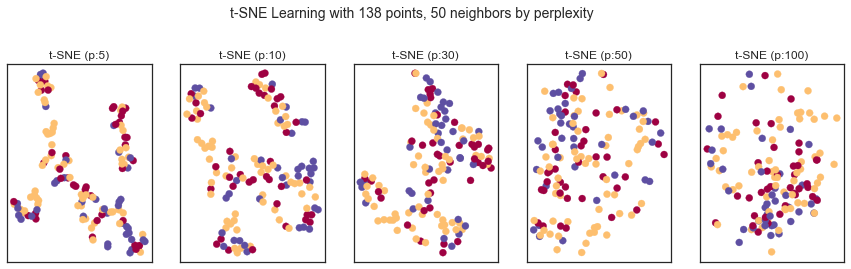

In [53]:
perplexity = [5,10,30,50,100]

fig = plt.figure(figsize=(15, 8))
plt.suptitle("t-SNE Learning with %i points, %i neighbors by perplexity"
             % (len(points), n_neighbors), fontsize=14)

for i,p in enumerate(perplexity):
    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, perplexity=p, init='pca',n_iter=5000, random_state=0)
    Y = tsne.fit_transform(X)
    t1 = time()
    print("t-SNE: %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(251+i)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("t-SNE (p:%d)" % (p))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

plt.show()